#  Standard Profile Likelihood Demo
Standard demo of the Profile Likelihood calculator
StandardProfileLikelihoodDemo

This is a standard demo that can be used with any ROOT file
prepared in the standard way.  You specify:
 - name for input ROOT file
 - name of workspace inside ROOT file that holds model and data
 - name of ModelConfig that specifies details for calculator tools
 - name of dataset

With default parameters the macro will attempt to run the
standard hist2workspace example and read the ROOT file
that it produces.

The actual heart of the demo is only about 10 lines long.

The ProfileLikelihoodCalculator is based on Wilks's theorem
and the asymptotic properties of the profile likelihood ratio
(eg. that it is chi-square distributed for the true value).




**Author:** Kyle Cranmer  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:30 AM.</small></i>

In [1]:
%%cpp -d
#include "TFile.h"
#include "TROOT.h"
#include "TSystem.h"
#include "RooWorkspace.h"
#include "RooAbsData.h"
#include "RooRealVar.h"

#include "RooStats/ModelConfig.h"
#include "RooStats/ProfileLikelihoodCalculator.h"
#include "RooStats/LikelihoodInterval.h"
#include "RooStats/LikelihoodIntervalPlot.h"

In [2]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace RooFit;
using namespace RooStats;

In [3]:
struct ProfileLikelihoodOptions {

   double confLevel = 0.95;
   int nScanPoints = 50;
   bool plotAsTF1 = false;
   double poiMinPlot = 1;
   double poiMaxPlot = 0;
   bool doHypoTest = false;
   double nullValue = 0;
};

ProfileLikelihoodOptions optPL;

 Arguments are defined. 

In [4]:
const char *infile = "";
const char *workspaceName = "combined";
const char *modelConfigName = "ModelConfig";
const char *dataName = "obsData";

In [5]:
double confLevel = optPL.confLevel;
double nScanPoints = optPL.nScanPoints;
bool plotAsTF1 = optPL.plotAsTF1;
double poiXMin = optPL.poiMinPlot;
double poiXMax = optPL.poiMaxPlot;
bool doHypoTest = optPL.doHypoTest;
double nullParamValue = optPL.nullValue;

-------------------------------------------------------
 First part is just to access a user-defined file
 or create the standard example file if it doesn't exist

In [6]:
const char *filename = "";
if (!strcmp(infile, "")) {
   filename = "results/example_combined_GaussExample_model.root";
   bool fileExist = !gSystem->AccessPathName(filename); // note opposite return code
   // if file does not exists generate with histfactory
   if (!fileExist) {
#ifdef _WIN32
      cout << "HistFactory file cannot be generated on Windows - exit" << endl;
      return;
#endif
      // Normally this would be run on the command line
      cout << "will run standard hist2workspace example" << endl;
      gROOT->ProcessLine(".! prepareHistFactory .");
      gROOT->ProcessLine(".! hist2workspace config/example.xml");
      cout << "\n\n---------------------" << endl;
      cout << "Done creating example input" << endl;
      cout << "---------------------\n\n" << endl;
   }

} else
   filename = infile;

Try to open the file

In [7]:
TFile *file = TFile::Open(filename);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



If input file was specified byt not found, quit

In [8]:
if (!file) {
   cout << "StandardRooStatsDemoMacro: Input file " << filename << " is not found" << endl;
   return;
}

-------------------------------------------------------
 Tutorial starts here
 -------------------------------------------------------

Get the workspace out of the file

In [9]:
RooWorkspace *w = (RooWorkspace *)file->Get(workspaceName);
if (!w) {
   cout << "workspace not found" << endl;
   return;
}

Get the modelconfig out of the file

In [10]:
ModelConfig *mc = (ModelConfig *)w->obj(modelConfigName);

Get the modelconfig out of the file

In [11]:
RooAbsData *data = w->data(dataName);

Make sure ingredients are found

In [12]:
if (!data || !mc) {
   w->Print();
   cout << "data or ModelConfig was not found" << endl;
   return;
}

---------------------------------------------
 create and use the ProfileLikelihoodCalculator
 to find and plot the 95% confidence interval
 on the parameter of interest as specified
 in the model config

In [13]:
ProfileLikelihoodCalculator pl(*data, *mc);
pl.SetConfidenceLevel(confLevel); // 95% interval
LikelihoodInterval *interval = pl.GetInterval();

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- createNLL: caching constraint set under name CONSTR_OF_PDF_simPdf_FOR_OBS_channelCat:obs_x_channel1 with 4 entries
[#1] INFO:Minization --  Including the following contraint terms in minimization: (alpha_syst2Constraint,alpha_syst3Constraint,gamma_stat_channel1_bin_0_constraint,gamma_stat_channel1_bin_1_constraint)
[#1] INFO:Minization -- The following global observables have been defined: (nom_alpha_syst2,nom_alpha_syst3,nom_gamma_stat_channel1_bin_0,nom_gamma_stat_channel1_bin_1)
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit / Migrad with strategy 1
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_simPdf_obsData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooMinimizer::optimizeConst: ac

Print out the interval on the first parameter of interest

In [14]:
RooRealVar *firstPOI = (RooRealVar *)mc->GetParametersOfInterest()->first();
cout << "\n>>>> RESULT : " << confLevel * 100 << "% interval on " << firstPOI->GetName() << " is : ["
     << interval->LowerLimit(*firstPOI) << ", " << interval->UpperLimit(*firstPOI) << "]\n " << endl;


>>>> RESULT : 95% interval on SigXsecOverSM is : [Warning: lower value for SigXsecOverSM is at limit 0
0, 2.32744]
 


Make a plot

In [15]:
cout << "making a plot of the profile likelihood function ....(if it is taking a lot of time use less points or the "
        "TF1 drawing option)\n";
LikelihoodIntervalPlot plot(interval);
plot.SetNPoints(nScanPoints); // do not use too many points, it could become very slow for some models
if (poiXMin < poiXMax)
   plot.SetRange(poiXMin, poiXMax);
TString opt;
if (plotAsTF1)
   opt += TString("tf1");
plot.Draw(opt); // use option TF1 if too slow (plot.Draw("tf1")

making a plot of the profile likelihood function ....(if it is taking a lot of time use less points or the TF1 drawing option)
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_obsData_with_constr_Profile[SigXsecOverSM]) Creating instance of MINUIT
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_simPdf_obsData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_obsData_with_constr_Profile[SigXsecOverSM]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_obsData_with_constr_Profile[SigXsecOverSM]) minimum found at (SigXsecOverSM=1.11511)
.
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_obsData_with_constr_Profile[SigXsecOverSM]) Creating instance of MINUIT
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_simPdf_obsData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:M

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


If requested perform also an hypothesis test for the significance

In [16]:
if (doHypoTest) {
   RooArgSet nullparams("nullparams");
   nullparams.addClone(*firstPOI);
   nullparams.setRealValue(firstPOI->GetName(), nullParamValue);
   pl.SetNullParameters(nullparams);
   std::cout << "Perform Test of Hypothesis : null Hypothesis is " << firstPOI->GetName() << nullParamValue
             << std::endl;
   auto result = pl.GetHypoTest();
   std::cout << "\n>>>> Hypotheis Test Result \n";
   result->Print();
}

Draw all canvases 

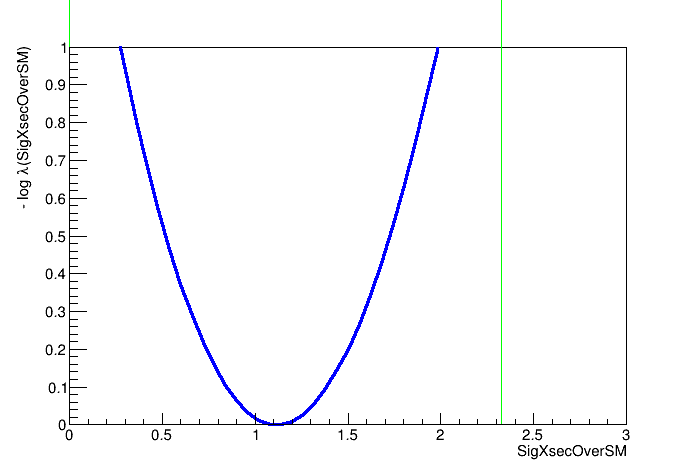

In [17]:
gROOT->GetListOfCanvases()->Draw()